<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week7/BiRNN_ReviewTokoBaju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Model BiRNN menggunakan TensorFlow : ReviewTokoBaju.csv🍳**

## Instalasi Keras untuk HyperTuning

In [ ]:
!pip install -q keras-tuner


In [ ]:
# Import semua libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import keras_tuner as kt

##Load Dataset

In [ ]:
# Step 1: Load dataset
df = pd.read_csv('/content/ReviewTokoBaju.csv')  # ganti ke path lokal kalau beda


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


#PreProcessing

In [ ]:
# Step 2: Ambil texts dan labels (sesuai dataset)
texts = df['Review Text'].fillna('')  # handle missing review
labels = df['Recommended IND']        # label 0 atau 1

In [ ]:
# Step 3: Preprocessing - Tokenizing dan Padding
max_vocab = 10000
max_len = 100


In [ ]:
tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)


In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


##Build Model

In [ ]:
# Step 4: Build BiRNN model function for tuner
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=max_vocab,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=max_len
    ))
    model.add(Bidirectional(LSTM(
        hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False
    )))
    model.add(Dense(
        hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dropout(
        hp.Float('dropout_rate', 0.2, 0.5, step=0.1)
    ))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'adamax']),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    return model


##Hyperparameter Tuning

In [ ]:
# Step 5: Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # coba 5 kombinasi terbaik
    executions_per_trial=1,
    directory='BiRNN_tuning',
    project_name='review_tokobaju'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Cari hyperparameter terbaik
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Trial 5 Complete [00h 01m 43s]
val_accuracy: 0.8997445702552795

Best val_accuracy So Far: 0.9010217189788818
Total elapsed time: 00h 08m 58s


In [ ]:
# Ambil model terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Embedding Dim: {best_hps.get('embedding_dim')}
- LSTM Units: {best_hps.get('lstm_units')}
- Dense Units: {best_hps.get('dense_units')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Optimizer: {best_hps.get('optimizer')}
""")


Best Hyperparameters:
- Embedding Dim: 64
- LSTM Units: 160
- Dense Units: 64
- Dropout Rate: 0.2
- Optimizer: adam



##Train Model

In [ ]:
# Step 6: Train Ulang Model dengan Hyperparameter Terbaik
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


588/588 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8346 - auc_4: 0.7393 - loss: 0.4020 - precision_4: 0.8569 - recall_4: 0.9613 - val_accuracy: 0.8606 - val_auc_4: 0.8895 - val_loss: 0.3144 - val_precision_4: 0.8689 - val_recall_4: 0.9771
Epoch 2/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8990 - auc_4: 0.9338 - loss: 0.2393 - precision_4: 0.9352 - recall_4: 0.9426 - val_accuracy: 0.8955 - val_auc_4: 0.9291 - val_loss: 0.2514 - val_precision_4: 0.9400 - val_recall_4: 0.9319
Epoch 3/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9289 - auc_4: 0.9591 - loss: 0.1862 - precision_4: 0.9575 - recall_4: 0.9558 - val_accuracy: 0.8914 - val_auc_4: 0.9079 - val_loss: 0.3225 - val_precision_4: 0.9149 - val_recall_4: 0.9563
Epoch 4/10
588/588 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9387 - auc_4: 0.9686 - loss: 0.1627 - precision_4: 0.9621 - recall_4: 0.9638 - val_accuracy: 0.8838 - val_auc_4: 0.9090 - val_loss: 0.2912 - val_precision_4: 0.9082 - val_recal

##Matriks Evaluasi

In [ ]:
# Print Akurasi di Train Set
train_loss, train_acc, train_prec, train_rec, train_auc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Set - Accuracy: {train_acc*100:.2f}% | Precision: {train_prec:.2f} | Recall: {train_rec:.2f} | AUC: {train_auc:.2f}")

# Print Akurasi di Test Set
test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Set - Accuracy: {test_acc*100:.2f}% | Precision: {test_prec:.2f} | Recall: {test_rec:.2f} | AUC: {test_auc:.2f}")


Training Set - Accuracy: 97.89% | Precision: 0.99 | Recall: 0.99 | AUC: 0.99
Testing Set - Accuracy: 88.70% | Precision: 0.92 | Recall: 0.95 | AUC: 0.88


In [ ]:
# Step 7: Evaluate Model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       851
           1       0.92      0.95      0.93      3847

    accuracy                           0.89      4698
   macro avg       0.82      0.78      0.80      4698
weighted avg       0.88      0.89      0.88      4698



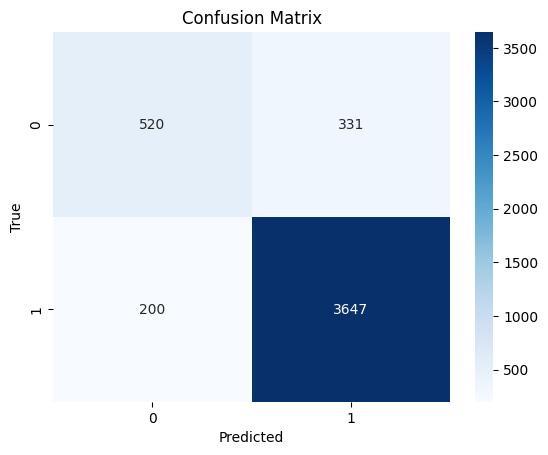

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


##Visualisasi

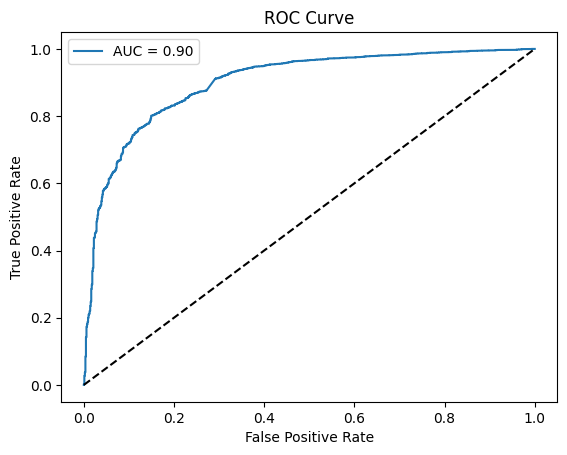

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Loss Curve')

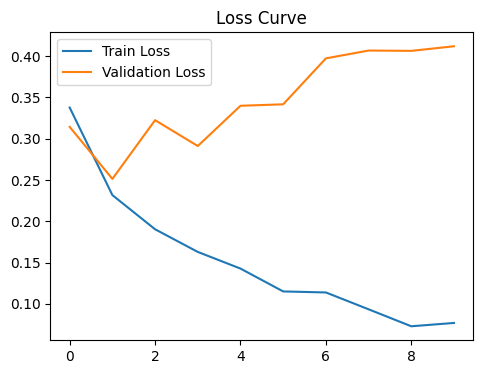

In [ ]:
# Step 8: Visualisasi Loss dan Accuracy
plt.figure(figsize=(12, 4))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

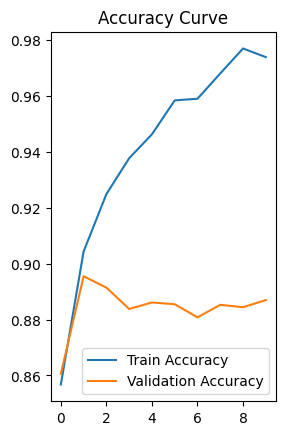

In [ ]:
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()